In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visits
df = df[df["NACCVNUM"] == 1]

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT","CBSTROKE"
    "CVAFIB", "PD", "SEIZURES", "TRAUMBRF", "HYPERCHO"
]
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOCCAS",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCTBI", "CVHATT",
    "CVAFIB", "PD", "SEIZURES", "TRAUMBRF", "HYPERCHO"
]

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOCCAS"].astype(float)
df["APOE_Risk"] = (df["NACCNE4S"] == 2).astype(int) + (df["NACCNE4S"] == 1).astype(int) * 0.5
df.drop(columns=["NACCNE4S"], inplace=True)

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk"]
feature_list = original_features + engineered_features
X = df[feature_list]
y = df["DEMENTED"]

# Identify numerical and categorical columns
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA",
                  "Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk"]
categorical_cols = ["SEX", "NACCNIHR", "NACCFAM", "TOBAC100", "ALCOHOL",
                    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCTBI", "CVHATT","CBSTROKE"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ================================
# 3. Train-Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# ================================
# 4. ANN Model Definition
# ================================
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Build model
input_shape = X_train_processed.shape[1]
ann_model = build_ann_model(input_shape)

# ================================
# 5. Model Training
# ================================
history = ann_model.fit(X_train_processed, y_train, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_test_processed, y_test), 
                        verbose=1)

# ================================
# 6. Evaluation
# ================================
y_proba = ann_model.predict(X_test_processed).flatten()
threshold = 0.35  # Can be adjusted dynamically
y_pred = (y_proba >= threshold).astype(int)

print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Find best threshold dynamically
best_threshold = 0.3
best_f1 = 0
for t in np.arange(0.3, 0.5, 0.05):  # Try thresholds from 0.3 to 0.5
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Best Threshold: {best_threshold} with F1-score: {best_f1}")


In [ ]:
# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visits

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES", "CVAFIB", "HYPERCHO", "CBSTROKE", "NACCMOM", "NACCDAD", "DEPOTHR"
]

binary_conversion_cols = [
    "ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"
]
df[binary_conversion_cols] = df[binary_conversion_cols].map(lambda x: 1 if x == 1 or x == 2 else 0)

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"]) * (df["Age_Education_Ratio"])
df["NACCHIST"] = (df["NACCFAM"].astype(float) + 1) * (df["NACCMOM"].astype(float) + 1) * (df["NACCDAD"].astype(float) + 1)
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "Cognitive_Risk",
                       "NACCHIST"]
feature_list = original_features + engineered_features
feature_list.remove("NACCMOM")
feature_list.remove("NACCDAD")
feature_list.remove("NACCFAM")
y = df["DEMENTED"]
X = df[feature_list]

# Identify column types
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA"] + engineered_features
binary_cols = ["SEX", "TOBAC100", "DEP2YRS", "DEPOTHR"] + binary_conversion_cols
categorical_cols = ["NACCNIHR"]


# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])
# ================================
# 3. Train-Test Split
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. ANN Model Definition
# ================================
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
input_shape = X_train_processed.shape[1]
ann_model = build_ann_model(input_shape)

# ================================
# 5. Model Training with Early Stopping
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ann_model.fit(X_train_processed, y_train, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_val_processed, y_val), 
                        callbacks=[early_stopping],
                        verbose=1)

# ================================
# 7. Evaluation
# ================================
y_proba = ann_model.predict(X_test_processed).flatten()

# Tune threshold for best F1-score
best_threshold = 0.3
best_f1 = 0
for t in np.arange(0.3, 0.6, 0.05):
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# Apply optimal threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_proba))



# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Dementia", "Dementia"], 
            yticklabels=["No Dementia", "Dementia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

<ipython-input-11-2bdf5e32ef9f>:21: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3725/3725 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8917 - loss: 0.2588 - val_accuracy: 0.9228 - val_loss: 0.2020
Epoch 2/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9232 - loss: 0.2043 - val_accuracy: 0.9231 - val_loss: 0.2016
Epoch 3/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9255 - loss: 0.1993 - val_accuracy: 0.9249 - val_loss: 0.1993
Epoch 4/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9266 - loss: 0.1971 - val_accuracy: 0.9250 - val_loss: 0.1963
Epoch 5/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9273 - loss: 0.1952 - val_accuracy: 0.9254 - val_loss: 0.1957
Epoch 6/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9257 - loss: 0.1966 - val_accuracy: 0.9250 - val_loss: 0.1955
Epoch 7/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9262 - loss: 0.1937 - val_accuracy: 0.9257 - val_loss: 0.1953
Epoch 8/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9269 - loss: 0.1944 - val_accurac

<ipython-input-1-9fac02840e00>:21: DtypeWarning: Columns (20,22,24,26,28,41,44,46,48,51,61,63,65,67,69,71,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,134,156,165,176,179,189,217,220,222,224,226,228,230,232,234,236,238,240,242,244,246,248,250,252,254,256,258,260,262,264,266,268,270,272,382,397,399,401,419,421,423,432,445,454,494,574,605,613,638,674,690,704,707,710,715,727,738,744,746,803,804,809,810,811,812,820,831,833,835,837,843,904,959,960,961,969,970,971,972,982,1004,1007,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regula

Epoch 1/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8784 - loss: 0.2897 - val_accuracy: 0.9220 - val_loss: 0.2045
Epoch 2/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9204 - loss: 0.2107 - val_accuracy: 0.9229 - val_loss: 0.2011
Epoch 3/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9232 - loss: 0.2041 - val_accuracy: 0.9240 - val_loss: 0.1993
Epoch 4/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9250 - loss: 0.2011 - val_accuracy: 0.9240 - val_loss: 0.1996
Epoch 5/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9237 - loss: 0.2031 - val_accuracy: 0.9247 - val_loss: 0.1978
Epoch 6/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9245 - loss: 0.2007 - val_accuracy: 0.9244 - val_loss: 0.1984
Epoch 7/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9233 - loss: 0.2011 - val_accuracy: 0.9246 - val_loss: 0.1980
Epoch 8/50
3725/3725 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9246 - loss: 0.1986 

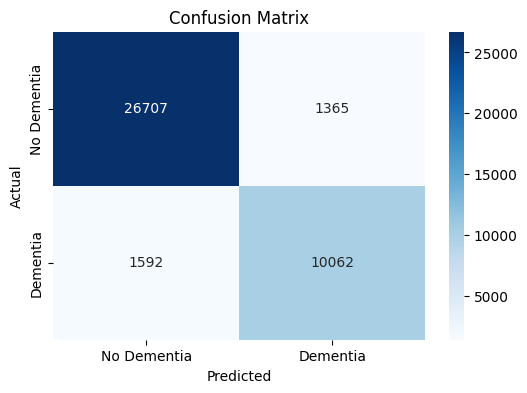

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visits

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "CVAFIB", "HYPERCHO","STROKE"
]

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOCCAS"].astype(float)
df["APOE_Risk"] = (df["NACCNE4S"] == 2).astype(int) + (df["NACCNE4S"] == 1).astype(int) * 0.5
df.drop(columns=["NACCNE4S"], inplace=True)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"] + 1) * (df["Age_Education_Ratio"]+1)

# Define features and target

engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk","Cognitive_Risk"]
feature_list = original_features + engineered_features
X = df[feature_list]
y = df["DEMENTED"]

# Identify numerical and categorical columns
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA",
                  "Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk","Cognitive_Risk"]
categorical_cols = ["SEX", "NACCNIHR", "NACCFAM", "TOBAC100", "ALCOHOL",
                    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCTBI", "CVHATT",
                    "CVAFIB", "HYPERCHO","STROKE"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ================================
# 3. Train-Test Split
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. ANN Model Definition
# ================================
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
input_shape = X_train_processed.shape[1]
ann_model = build_ann_model(input_shape)

# ================================
# 5. Model Training with Early Stopping
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ann_model.fit(X_train_processed, y_train, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_val_processed, y_val), 
                        callbacks=[early_stopping],
                        verbose=1)

# ================================
# 7. Evaluation
# ================================
y_proba = ann_model.predict(X_test_processed).flatten()

# Tune threshold for best F1-score
best_threshold = 0.3
best_f1 = 0
for t in np.arange(0.3, 0.6, 0.05):
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# Apply optimal threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_proba))



# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Dementia", "Dementia"], 
            yticklabels=["No Dementia", "Dementia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train logistic regression on MEMORY alone
model = LogisticRegression()
model.fit(X_train[["MEMORY"]], y_train)
preds = model.predict(X_test[["MEMORY"]])
acc = accuracy_score(y_test, preds)

print(f"Feature: NACCAGE, Accuracy: {acc:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# ================================NEW YES
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visors 
df = df[df["NACCVNUM"] == 1]

# Feature selection (original + additional features)
# Original Features
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES", "CVAFIB", "HYPERCHO", "CBSTROKE", "NACCMOM", "NACCDAD","DEPOTHR","MEMORY"
]

# Convert categorical variables to binary (1 if present, 0 otherwise)
binary_conversion_cols = [
    "ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"
]
df[binary_conversion_cols] = df[binary_conversion_cols].applymap(lambda x: 1 if x > 0 else 0)

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["APOE_Risk"] = (2 * (df["NACCNE4S"] == 2)).astype(int) + (df["NACCNE4S"] == 1).astype(int)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"]) * (df["Age_Education_Ratio"])
df["NACCHIST"]= (df["NACCFAM"].astype(float)+1) * (df["NACCMOM"].astype(float)+1) * (df["NACCDAD"].astype(float)+1)
df["Cognitive_AgeEdu_Interaction"] = (df["Cognitive_Risk"].astype(float) + 1) * (df["Age_Education_Ratio"].astype(float) + 1)
df["Education_Cognition"] = df["EDUC"] + df["NACCMOCA"]
df["Cardio_Lifestyle_Interaction"] = (df["Cardio_Risk"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Lifestyle_Interaction"] = (df["DEP2YRS"] + 1) * (df["Lifestyle_Risk"] + 1)
df["Dep_Cardio_Impact"] = (0.6 * (df["DEP2YRS"] + 1)) + (0.4 * (df["Cardio_Risk"] + 1))
df["SEX"] = df["SEX"].map({1: 0, 2: 1})

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk", "Cognitive_Risk","NACCHIST","Cognitive_AgeEdu_Interaction","Education_Cognition",
                  "Cardio_Lifestyle_Interaction","Dep_Lifestyle_Interaction","Dep_Cardio_Impact"]
feature_list = original_features + engineered_features
X = df[feature_list]
feature_list.remove("MEMORY")
feature_list.remove("NACCMOM")
feature_list.remove("NACCDAD")
feature_list.remove("NACCFAM")
y = df["DEMENTED"]

# Identify numerical and categorical columns
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA",
                  "Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk", "Cognitive_Risk","NACCHIST","Cognitive_AgeEdu_Interaction","Education_Cognition",
                  "Cardio_Lifestyle_Interaction","Dep_Lifestyle_Interaction","Dep_Cardio_Impact"]
binary_cols = ["SEX", "TOBAC100", "DEP2YRS", "DEPOTHR","ALCOHOL", "NACCTBI", "DIABETES", "HYPERTEN", "CVHATT",
    "SEIZURES", "HYPERCHO", "CBSTROKE", "CVAFIB"]  # No One-Hot Encoding
categorical_cols = [ "NACCNIHR"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  # No encoding needed
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ================================
# 3. Train-Test Split
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. ANN Model Definition
# ================================
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
input_shape = X_train_processed.shape[1]
ann_model = build_ann_model(input_shape)

# ================================
# 5. Model Training with Early Stopping
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ann_model.fit(X_train_processed, y_train, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_val_processed, y_val), 
                        callbacks=[early_stopping],
                        verbose=1)

# ================================
# 7. Evaluation
# ================================
y_proba = ann_model.predict(X_test_processed).flatten()

# Tune threshold for best F1-score
best_threshold = 0.3
best_f1 = 0
for t in np.arange(0.3, 0.6, 0.05):
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# Apply optimal threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_proba))



# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Dementia", "Dementia"], 
            yticklabels=["No Dementia", "Dementia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, f1_score,confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visors 
df = df[df["NACCVNUM"] == 1]

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOHOL",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMOCA", "NACCTBI", "CVHATT",
    "SEIZURES","CVAFIB","HYPERCHO","CBSTROKE","NACCMOM","NACCDAD"
]

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOHOL"].astype(float)
df["APOE_Risk"] = (2*(df["NACCNE4S"] == 2)).astype(int) + (df["NACCNE4S"] == 1).astype(int)
df["Cognitive_Risk"] = (0.5 * df["MEMORY"] ) * (df["Age_Education_Ratio"])
df["SEX"] = df["SEX"].map({1: 0, 2: 1})
# Define features and target

engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk","Cognitive_Risk"]


feature_list = original_features + engineered_features
X = df[feature_list]
y = df["DEMENTED"]

# Identify numerical and categorical columns
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMOCA",
                  "Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk","Cognitive_Risk"]
binary_cols = ["SEX", "TOBAC100", "DEP2YRS","DEPOTHR" "NACCFAM","NACCMOM","NACCDAD"]  # No One-Hot Encoding
categorical_cols = [ "NACCNIHR", "ALCOHOL","NACCTBI"
                    "DIABETES", "HYPERTEN", "CVHATT",
                    "SEIZURES", "HYPERCHO","CBSTROKE","CVAFIB"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))  # No encoding needed
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# ================================
# 3. Train-Test Split
# ================================
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Fit preprocessor
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# 5. ANN Model Definition
# ================================
def build_ann_model(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model
    
input_shape = X_train_processed.shape[1]
ann_model = build_ann_model(input_shape)

# ================================
# 5. Model Training with Early Stopping
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = ann_model.fit(X_train_processed, y_train, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_val_processed, y_val), 
                        callbacks=[early_stopping],
                        verbose=1)

# ================================
# 7. Evaluation
# ================================
y_proba = ann_model.predict(X_test_processed).flatten()

# Tune threshold for best F1-score
best_threshold = 0.3
best_f1 = 0
for t in np.arange(0.3, 0.6, 0.05):
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"Optimal Threshold: {best_threshold:.2f} with F1-score: {best_f1:.4f}")

# Apply optimal threshold
y_pred = (y_proba >= best_threshold).astype(int)

# Classification Report
print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))
print("Test Set ROC-AUC Score:", roc_auc_score(y_test, y_proba))



# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Dementia", "Dementia"], 
            yticklabels=["No Dementia", "Dementia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np

# ================================
# 1. Load Dataset and Preprocess
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visits
df = df[df["NACCVNUM"] == 1]

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOCCAS",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMMSE", "NACCTBI", "CVHATT",
    "CVAFIB", "PD", "SEIZURES", "TRAUMBRF", "HYPERCHO", "MEMORY"
]

# Define target variable
X = df[original_features]
y = df["DEMENTED"]

# Convert categorical variables to numerical (for mutual information)
X = X.copy()
for col in X.select_dtypes(include=['object', 'category']).columns:
    X[col], _ = X[col].factorize()

# Impute missing values with median
X.fillna(X.median(), inplace=True)

# ================================
# 2. Compute Mutual Information
# ================================
mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Create DataFrame for better visualization
mi_df = pd.DataFrame({'Feature': original_features, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display ranked features
print(mi_df)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ================================
# 1. Load and Preprocess Dataset
# ================================
df = pd.read_csv("/kaggle/input/nacccsv/investigator_nacc68.csv")  # Replace with actual file path

# Define missing value codes
missing_values = [88, 888, 9, 99, 999, -4.4, -4]
df.replace(missing_values, np.nan, inplace=True)

# Keep only baseline visits
df = df[df["NACCVNUM"] == 1]

# Feature selection (original + additional features)
original_features = [
    "NACCAGE", "SEX", "NACCNIHR", "EDUC", "NACCFAM", "TOBAC100", "ALCOCCAS",
    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCBMI", "NACCMMSE", "NACCTBI", "CVHATT",
    "CVAFIB", "PD", "SEIZURES", "TRAUMBRF", "HYPERCHO", "MEMORY"
]

# Feature Engineering
df["Cardio_Risk"] = df["DIABETES"].astype(float) + df["HYPERTEN"].astype(float) + df["NACCBMI"].astype(float)
df["Age_Education_Ratio"] = df["NACCAGE"].astype(float) / (df["EDUC"].astype(float) + 1)
df["Lifestyle_Risk"] = df["TOBAC100"].astype(float) + df["ALCOCCAS"].astype(float)
df["APOE_Risk"] = (df["NACCNE4S"] == 2).astype(int) + (df["NACCNE4S"] == 1).astype(int) * 0.5
df.drop(columns=["NACCNE4S"], inplace=True)

# Define features and target
engineered_features = ["Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk"]
feature_list = original_features + engineered_features
X = df[feature_list]
y = df["DEMENTED"]

# Identify numerical and categorical columns
numerical_cols = ["NACCAGE", "EDUC", "NACCBMI", "NACCMMSE",
                  "Cardio_Risk", "Age_Education_Ratio", "Lifestyle_Risk", "APOE_Risk"]
categorical_cols = ["SEX", "NACCNIHR", "NACCFAM", "TOBAC100", "ALCOCCAS",
                    "DIABETES", "HYPERTEN", "DEP2YRS", "NACCTBI", "CVHATT",
                    "CVAFIB", "PD", "SEIZURES", "TRAUMBRF", "HYPERCHO", "MEMORY"]

# ================================
# 2. Preprocessing Pipelines
# ================================
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Fit transformer to extract feature names
preprocessor.fit(X)

# Get transformed feature names (handle one-hot encoding)
num_feature_names = numerical_cols
cat_feature_names = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_feature_names = list(num_feature_names) + list(cat_feature_names)

# Apply preprocessing
X_processed = preprocessor.transform(X)

# ================================
# 3. Compute Mutual Information
# ================================
mi_scores = mutual_info_classif(X_processed, y, discrete_features='auto')

# Create DataFrame for visualization
mi_df = pd.DataFrame({'Feature': all_feature_names, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display results
print("\nMutual Information Scores:")
print(mi_df)
